# Section 1: binary phase evaluation (fixed parameters)

We model a binary system embedded in an accretion disk, along with a dark matter spike and gravitational waves emission.
The goal for our modelization is to produce an estimate of the following quantity: 

\begin{equation}
    \dot{r} = \dot{r}_{\mathrm{gas}} + \dot{r}_{\mathrm{DF}} + \dot{r}_{\mathrm{GW}}\text{,}
\end{equation}

where $\dot{r}_\mathrm{gas}$ is the contribution coming from gas torques from the accretion disk surrounding the binary, $\dot{r}_\mathrm{DF}$ is the effect of dynamical friction from the presence of the dark matter spike, and $\dot{r}_\mathrm{GW}$ is the contribution from the gravitational waves emission. Specifically, we adopt the classical Newtonian formalism, computing the results from the reduced mass-system, and in case assuming that $m_1 \gg m_2$.

Once the shape of $\dot{r}$ is clear, one can evaluate the phase of the binary system from a generic $f$-frequency to the $f_{\mathrm{isco}}$-frequency. Assuming circular orbits the frequency is:

\begin{equation}
    f = \frac{1}{\pi} \sqrt{\frac{G(m_1 + m_2)}{r^3}}\text{.}
\end{equation}

We can evaluate $\Phi(f)$ as: 

\begin{equation}
    \Phi(f) = 2\pi \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{df'} f' df'\text{,}
\end{equation}

where the relation $\frac{dt}{df'}$ is extracted directly from the expression in the above equation by the following chain rule: $\frac{dr}{dt} \frac{df}{dr} = \frac{df}{dt}$. 

### Note!

If we already integrate on the grid that starts from $\textit{isco}$ we are subtracting the $\Phi(f_{\mathrm{isco}}) = \int_{f_{\mathrm{isco}}}^{f_{\mathrm{isco}}} \frac{dt}{df} f' df' = 0$ to the phase $\Phi(f)$.

## Expressions for the $\dot{r}_i$ contributions

- Accretion disk's torques: 

\begin{equation}
    \dot{r}_\mathrm{gas} = - 2 \Sigma_0 \frac{r^{\gamma + 3/2}}{r_0^\gamma} \frac{G^{1/2} (m_1 + m_2)^{1/2}}{\mu} q^{2} \mathcal{M}^2\text{.}
\end{equation}

- Dark matter spike's dynamical friction:

Static:

\begin{equation}
\label{eq:r_dot_DF}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}}\text{,}
\end{equation}

- Gravitational waves: 

\begin{equation}
\label{eq:r_dot_gw}
    \dot{r}_{\mathrm{GW}} = - \frac{64 (m_1 + m_2) G^3 m_1 m_2}{5 c^5 r^3}\text{.}
\end{equation}

In the code, there will be enabled the possibility to choose which of these options to keep in the final formula, which will account for the sum of all the contributions the user requires. 

## Formulas to use and implement "in code" for the phase evaluation

I used the following quantities: 

- Derivative of f in radial separation:

\begin{equation}
\label{eq:dfdr}
    \frac{df}{dr} = \frac{1}{\pi} (-\frac{3}{2}) \sqrt{\frac{G (m_1 + m_2)}{r^5}}\text{.}\\
\end{equation}


- Inverse of f(r):

\begin{equation}
\label{eq:r(f)}
    r(f) = \sqrt[3]{\frac{G (m_1 + m_2)}{\pi^2 f^2}}\text{,}\\
\end{equation}

- Derivative of f in time:

\begin{equation}
\label{eq:dfdt}
    \frac{df}{dt} = \dot{r} \frac{df}{dr}\text{,}\\
\end{equation}

- Second derivative of the phase in time:

\begin{equation}
\label{eq:phi_dot-dot}
    \ddot{\Phi}(f) = 4 \pi^2 f \left(\frac{d\Phi(f)}{df}\right)^{-1} 
\end{equation}

# Code implementation

### Libraries and constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy as sp
from scipy.integrate import quad 
import pandas as pd

In [2]:
# Define some constants: 

G = 6.67408e-11 # kg^-1 m^3 / s^2
c = 299792458.0 # m / s
pc = 3.08567758149137e16 # m
m_sun = 1.98855e30 # kg

In [3]:
# Fix parameters:

m1 = 1e5 * m_sun #1.4e3 * m_sun
m2 = 10 * m_sun #1.4 * m_sun
q = m2/m1
M_tot = m1 + m2
mu = m1 * m2 / M_tot
chirp_mass = (m1 * m2)**(3/5) / (M_tot)**(1/5)

In [4]:
# Fix environments

# Spike: 

rho6 = 1.17 * 10**17 * m_sun / (pc)**3
r6 =  pc * 10**(-6)
gammas = 7/3
epsv = 0.58
logL = 1 / q**(1/2)

# Accretion disk: 

r_s = 2 * G * m1 / c**2 # Schwartzschild radius of m1
r0 = 3 * r_s
Mach = 100 
sigma0 = 1.5 * 10**10 / Mach**2
alpha = -1/2


r_isco = 6 * m1 * G / c**2 # of central bh

### Base functions $\rightarrow$ find phase $\Phi(f)$ 

In [5]:
def rho_dm(r):
    
    '''Finds the density profile of the dark matter using the above formulation.'''
    
    return rho6 * (r6 / r)**(gammas)

In [6]:
def sigma_acc(r): 
    
    '''Computes the accretion disk surface density.'''
    
    return sigma0 * (r / r0)**(alpha)

In [7]:
def rho_disk(r):
    
    '''Finds the density profile of the disk using \rho \simeq \Sigma(r)/(2h), where h = r / Mach.'''
    
    return sigma0 * (r / r0)**(alpha) / (2 * r / Mach) # set h = r / Mach

In [8]:
def frequency(r):
        
    '''Finds the binary frequency assuming circular orbits, at fixed radius r.'''
        
    return 1 / np.pi * np.sqrt(G * m1 / r**3)

In [9]:
def binary_separation(f):
        
    '''Finds the binary frequency assuming circular orbits, at fixed radius r.'''
        
    return (G * m1 / (f**2 * np.pi**2))**(1/3)

In [10]:
def df_dr(r): 
    
    '''Finds the binary frequency radial derivative assuming circular orbits.'''
        
    return 1 / np.pi * (- 3 / 2) * np.sqrt(G * M_tot / r**5)

In [11]:
def df_dt(r, dot_r): 
    
    '''Finds the binary frequency time derivative.'''
    
    return df_dr(r) * dot_r

In [12]:
def gas_torque(r): 
    
    '''Computes the accretion gas torque on the mass, in the migration type I regime.'''
    
    return - sigma_acc(r) * r**4 * (G * M_tot / r**3) * q**2 * Mach**2

In [13]:
def yes_or_no(elem):
    
    '''Checks whether you want a contribution or not. (could be made boolean directly)'''
        
    if elem=='y': 
        
        return 1
    
    return 0

In [14]:
def dot_r(r):
    
    '''Find the binary change in separation over time, asking the user to choose which contribution to keep.'''
        
    acc = ''
    dm = ''
    gw = ''
    
    
    while(acc != 'y' and acc != 'n'):
        print('Include the accretion contribution? (y/n)')
        acc = input()
    
    while(dm != 'y' and dm != 'n'):
        print('Include the dark matter contribution? (y/n)')
        dm = input()
    
    while(gw != 'y' and gw != 'n'):
        print('Include the GW contribution? (y/n)')
        gw = input()
    
    r_dot_acc = 0.5 * gas_torque(r) * m2**(-1) * r**(1/2) * (G * M_tot)**(-1/2)
    
    r_dot_dm = - 8 * np.pi * G**(1/2) * m2 * logL * rho6 * r6**(gammas) * epsv / (r**(gammas - 5/2) * m1 * M_tot**(1/2)) #* r**(5/2)
    
    r_dot_gw = - 64 * M_tot * G**3 * m1 * m2 / (5 * c**5 * r**3)
    
    
    return yes_or_no(acc) * r_dot_acc + yes_or_no(dm) * r_dot_dm + yes_or_no(gw) * r_dot_gw

In [15]:
def phase_f_by_hand(df_dt): 
    
    '''Finds the binary phase as a function of frequency.'''
    
    freqs = frequency(r_grid)
    to_integrate = 2 * np.pi * df_dt**(-1) * freqs 
    phase_f = []
    
    for b in freqs:  # range of values for the lower limit
        
        # Select the appropriate range of f values for integration
        f_range = freqs[freqs >= b]
        
        phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))

    return np.array(phase_f)

In [16]:
def phase_f(df_dt): 
    
    '''Finds the binary phase as a function of frequency'''
    
    freqs = frequency(r_grid)
    to_integrate = 2 * np.pi * df_dt**(-1) * freqs 
    phase = sp.integrate.cumulative_trapezoid(to_integrate, freqs)
    
    return np.array(phase)

In [17]:
def ddot_phase_f(df_dt): 
    
    '''Finds the binary second derivative phase as a function of frequency, using the equations above.'''
    
    return 2 * np.pi * df_dt

In [18]:
def h_0(f, ddot_phase):
    
    '''Finds the strain as a function of frequency, and \ddot{\Phi}'''
    
    return 1/2 * 4 * np.pi**(2/3) * G**(5/3) * chirp_mass**(5/3) * f**(2/3) / c**4 * (2 * np.pi / ddot_phase)**(1/2) / (4 * 10**9 * pc)

### Domain of the problem

We define the domain of the problem setting the grid that's based on LISA's sensitivity (minimum treshold). 

In [19]:
f_LISA = 1e-3 # Hz

r_max = binary_separation(f_LISA)

# set grid of radial distances
r_grid = np.linspace(r_isco, r_max, 10000)

### Density profiles

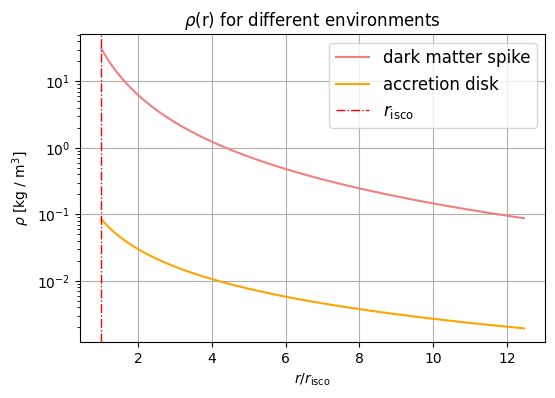

In [20]:
# Plot
plt.figure(figsize=(6, 4))

plt.semilogy(r_grid/r_isco, rho_dm(r_grid), c='lightcoral', linestyle='-', label='dark matter spike')
plt.semilogy(r_grid/r_isco, rho_disk(r_grid), c='orange', linestyle='-', label='accretion disk')
plt.axvline(x=1, c='red', label='$r_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
plt.xlabel('$r/r_{\mathrm{isco}}$', fontsize=10)  
plt.ylabel(r'$\rho$ [kg / m$^3$]', fontsize=10)  
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)  
plt.title(r'$\rho$(r) for different environments', fontsize=12)
plt.grid(True)  
plt.legend(fontsize='large')  
plt.show()

In [21]:
# Check the frequencies are ok:

freqs = frequency(r_grid)
f_isco = frequency(r_isco)

print('f_isco:', f_isco)
print('f_isco_grid:', freqs[0])

f_isco: 0.04397009835544325
f_isco_grid: 0.04397009835544325


### Phase to coalescence

In [22]:
df_dr_s = df_dr(r_grid)

In [23]:
dot_r_all = dot_r(r_grid)

Include the accretion contribution? (y/n)
y
Include the dark matter contribution? (y/n)
y
Include the GW contribution? (y/n)
y


In [24]:
dot_r_acc = dot_r(r_grid)

Include the accretion contribution? (y/n)
y
Include the dark matter contribution? (y/n)
n
Include the GW contribution? (y/n)
y


In [25]:
dot_r_dm = dot_r(r_grid)

Include the accretion contribution? (y/n)
n
Include the dark matter contribution? (y/n)
y
Include the GW contribution? (y/n)
y


In [26]:
dot_r_gw = dot_r(r_grid)

Include the accretion contribution? (y/n)
n
Include the dark matter contribution? (y/n)
n
Include the GW contribution? (y/n)
y


### Energy comparison

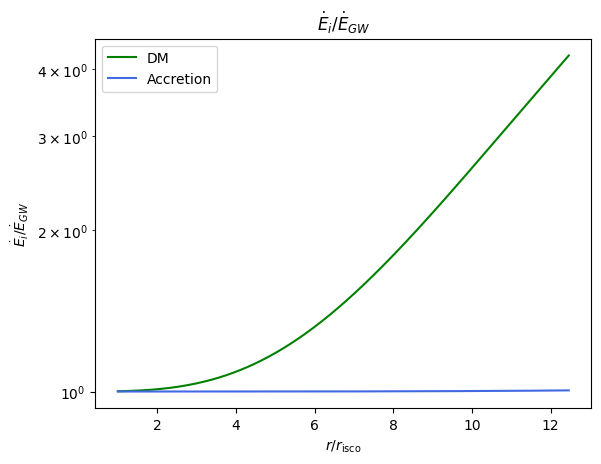

In [27]:
plt.semilogy(r_grid/r_isco, dot_r_dm/dot_r_gw, c='green', label='DM')
plt.semilogy(r_grid/r_isco, dot_r_acc/dot_r_gw, c='royalblue', label='Accretion')
plt.title("$\dot{E}_i / \dot{E}_{GW}$")
plt.ylabel("$\dot{E}_i / \dot{E}_{GW}$")
plt.xlabel("$r/r_{\mathrm{isco}}$")
plt.legend();

In [28]:
# Find phase for all cases

df_dt_all = df_dt(r_grid, dot_r_all)
df_dt_acc = df_dt(r_grid, dot_r_acc)
df_dt_dm = df_dt(r_grid, dot_r_dm)
df_dt_gw = df_dt(r_grid, dot_r_gw)

phi_all_bh = phase_f_by_hand(df_dt_all)
phi_acc_bh = phase_f_by_hand(df_dt_acc)
phi_dm_bh = phase_f_by_hand(df_dt_dm)
phi_gw_bh = phase_f_by_hand(df_dt_gw)

phi_all = phase_f(df_dt_all)
phi_acc = phase_f(df_dt_acc)
phi_dm = phase_f(df_dt_dm)
phi_gw = phase_f(df_dt_gw)

Check correspondance between numerical methods adopted (by-hand vs cum_trapz):

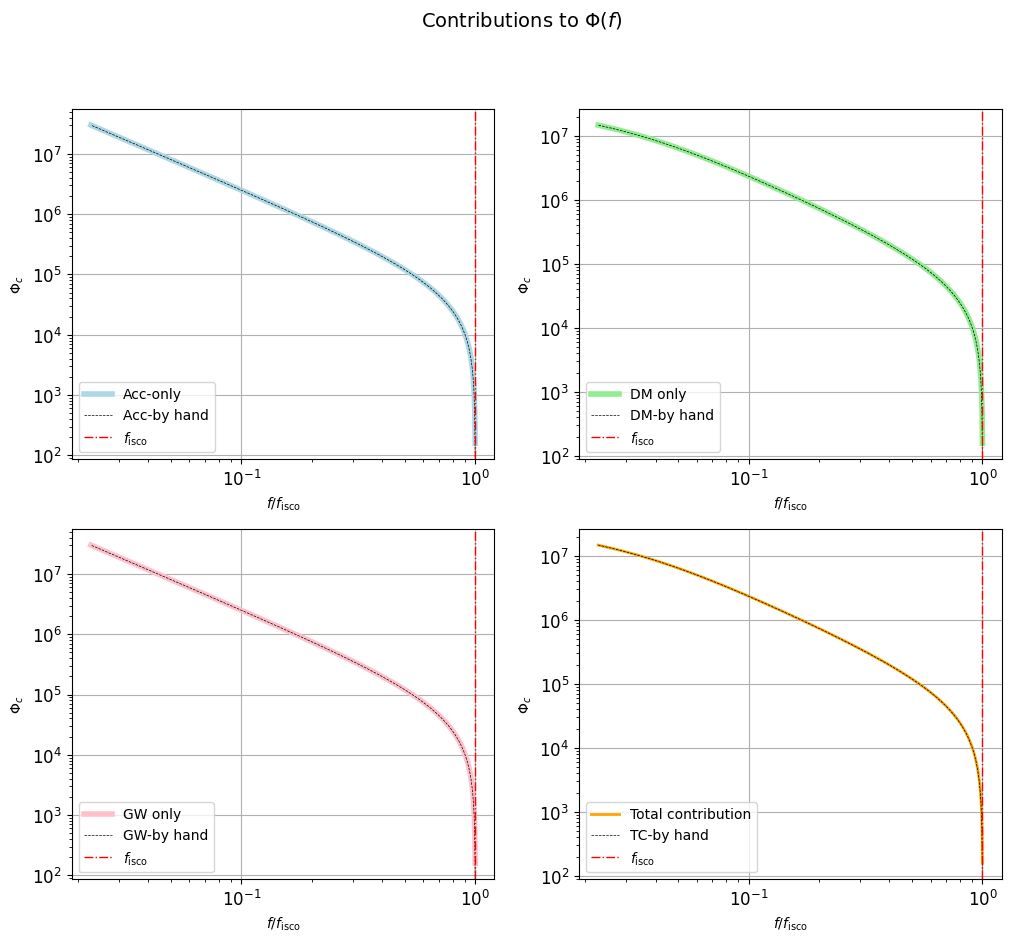

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

plt.suptitle('Contributions to $\Phi(f)$', fontsize=14)


axs[0, 0].loglog(freqs[:-1]/f_isco, -phi_acc, c='lightblue', linestyle='-', label='Acc-only', linewidth=4)
axs[0, 0].loglog(freqs/f_isco, -phi_acc_bh, c='black', linestyle='--', label='Acc-by hand', linewidth=0.5)
axs[0, 0].axvline(x=1, c='red', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
axs[0, 0].set_ylabel(r'$\Phi_c$', fontsize=10) 
axs[0, 0].tick_params(axis='x', labelsize=12)  
axs[0, 0].tick_params(axis='y', labelsize=12)  
axs[0, 0].grid(True)  
axs[0, 0].legend() 

axs[0, 1].loglog(freqs[:-1]/f_isco, -phi_dm, c='lightgreen', linestyle='-', label='DM only', linewidth=4)
axs[0, 1].loglog(freqs/f_isco, -phi_dm_bh, c='black', linestyle='--', label='DM-by hand', linewidth=0.5)
axs[0, 1].axvline(x=1, c='red', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
axs[0, 1].set_ylabel(r'$\Phi_c$', fontsize=10) 
axs[0, 1].tick_params(axis='x', labelsize=12)  
axs[0, 1].tick_params(axis='y', labelsize=12)  
axs[0, 1].grid(True)  
axs[0, 1].legend()  

axs[1, 0].loglog(freqs[:-1]/f_isco, -phi_gw, c='pink', linestyle='-', label='GW only', linewidth=4)
axs[1, 0].loglog(freqs/f_isco, -phi_gw_bh, c='black', linestyle='--', label='GW-by hand', linewidth=0.5)
axs[1, 0].axvline(x=1, c='red', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[1, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  
axs[1, 0].set_ylabel(r'$\Phi_c$', fontsize=10)
axs[1, 0].tick_params(axis='x', labelsize=12) 
axs[1, 0].tick_params(axis='y', labelsize=12) 
axs[1, 0].grid(True)
axs[1, 0].legend()  

axs[1, 1].loglog(freqs[:-1]/f_isco, -phi_all, c='orange', linestyle='-', label='Total contribution', linewidth=2)
axs[1, 1].loglog(freqs/f_isco, -phi_all_bh, c='black', linestyle='--', label='TC-by hand', linewidth=0.5)
axs[1, 1].axvline(x=1, c='red', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[1, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10) 
axs[1, 1].set_ylabel(r'$\Phi_c$', fontsize=10)
axs[1, 1].tick_params(axis='x', labelsize=12) 
axs[1, 1].tick_params(axis='y', labelsize=12) 
axs[1, 1].grid(True)  
axs[1, 1].legend()  

plt.show()

In [30]:
import pickle

# Step 2: Saving Variables
file_path = 'gw_only.pickle'

# Open the file in binary mode
with open(file_path, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(-phi_gw_bh, file)
    
# Step 2: Saving Variables
file_path0 = 'phi_accretion.pickle'

# Open the file in binary mode
with open(file_path0, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(-phi_acc_bh, file)
    
#----------------------------------

# Step 2: Saving Variables
file_path1 = 'r_grid.pickle'

# Open the file in binary mode
with open(file_path1, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(r_grid, file)
    
#----------------------------------
    

# Step 2: Saving Variables
file_path2 = 'dotracc_accretion.pickle'
    
# Open the file in binary mode
with open(file_path2, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(dot_r_acc, file)
    
    
#----------------------------------

# Step 2: Saving Variables
file_path3 = 'freqs_accretion.pickle'
    
# Open the file in binary mode
with open(file_path3, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(freqs, file)
    
#----------------------------------


# Step 2: Saving Variables
file_path4 = 'gas_torque.pickle'
    
# Open the file in binary mode
with open(file_path4, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(gas_torque(r_grid), file)
    
#----------------------------------

# Step 2: Saving Variables
file_path5 = 'dfdt.pickle'
    
# Open the file in binary mode
with open(file_path5, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(df_dt_acc, file)
    
#–--------------------------------

# Step 2: Saving Variables
file_path5 = 'dfdr.pickle'
    
# Open the file in binary mode
with open(file_path5, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(df_dr_s, file)

print("The variables have been saved successfully.")

The variables have been saved successfully.


In [ ]:
r0

See them in a single plot:

In [ ]:
# Plot
plt.figure(figsize=(8, 6))

plt.loglog(freqs, -phi_gw_bh, c='hotpink', label='GW only', linewidth=1, linestyle='--')
plt.loglog(freqs, -phi_acc_bh, c='deepskyblue', label='Acc-only', linewidth=1, linestyle='--')
plt.loglog(freqs, -phi_dm_bh, c='limegreen', label='DM-only', linewidth=1, linestyle='--')
plt.loglog(freqs, -phi_all_bh, c='darkorange', label='Total contribution', linewidth=1, linestyle='--')
plt.legend(fontsize='large')

plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Phase ($\Phi$)', fontsize=12)
plt.title('Contributions to phase ($\Phi$)', fontsize=14)
plt.grid(True)

plt.show()

### Dephasing

In [ ]:
# Check accretion dephasing with Pippa's article (...)

freqs_check = [0.0037489759073066706, 
               0.0045808203206109815,
               0.006397263952538412 ,
               0.010041836308031946 ,
               0.013676826091020286 ,
               0.018941312194911387 ,
               0.026341951000090097 ,
               0.035283168107176875 ,
               0.04257540311687632]
               
               
               
values_accretion_check = [31.422270942534333,
                          12.573248925511695, 
                          3.024565426161052, 
                          0.415704312981927, 
                          0.11071307035571255, 
                          0.026632648952219524, 
                          0.0057866996191441086, 
                          0.0010793173820116447, 
                          0.00009383734048371296]

In [ ]:
plt.loglog(freqs, (+phi_acc_bh - phi_gw_bh)/(2 * np.pi), c='grey', label='accretion')
plt.loglog(freqs, (+phi_dm_bh - phi_gw_bh)/(2 * np.pi), c='lightblue', label='dark matter')
plt.axvline(x=f_isco, c='red', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
plt.xlabel('$f$ [1/s]', fontsize=10)  # Increase x-label font size
plt.ylabel(r'$\Phi_i$', fontsize=10)  # Add y-label with increased font size
plt.xticks(fontsize=10)  # Increase tick font size for x-axis
plt.yticks(fontsize=10)  # Increase tick font size for y-axis
plt.grid(True)
plt.scatter(freqs_check, values_accretion_check, marker='o',  c='white', s=7, edgecolor='black', label='from paper')
plt.tick_params(axis='y', which='minor')
plt.xlim(10**(-3), 1.1 * f_isco)
plt.legend(fontsize='large');

### Testing the code on the analytical solution I found

Which is just the GW case.

In [ ]:
phi_gw_an = -G**(-5/3) * (M_tot)**(1/3) * c**5 / (16 * np.pi**(5/3) * m1 * m2) * (freqs**(-5/3) - f_isco**(-5/3))

In [ ]:
plt.plot(freqs/f_isco, phi_gw_an, c='black', linestyle='--', label='GW analytical', linewidth=1.5)
plt.plot(freqs/f_isco, phi_gw_bh, c='violet', linestyle='-', label='GW numerical', alpha=0.5, linewidth=2)
plt.xlabel('$f/f_{\mathrm{isco}}$ [1/s]', fontsize=10)  # Increase x-label font size
plt.ylabel(r'$\Phi$', fontsize=10)  # Add y-label with increased font size
plt.xticks(fontsize=10)  # Increase tick font size for x-axis
plt.yticks(fontsize=10)  # Increase tick font size for y-axis
plt.grid(True)  # Add gridlines
plt.legend();

### Second derivatives of the phase

In [ ]:
ddot_phase_all = ddot_phase_f(df_dt_all)
ddot_phase_acc = ddot_phase_f(df_dt_acc)
ddot_phase_dm = ddot_phase_f(df_dt_dm)
ddot_phase_gw = ddot_phase_f(df_dt_gw)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

plt.suptitle('Contributions to $\ddot{\Phi}(f)$', fontsize=14)


axs[0, 0].plot(freqs/f_isco, ddot_phase_acc, c='blue', linestyle='-', label='$\ddot{\Phi}_{\mathrm{acc}}$', linewidth=1.5)
axs[0, 0].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[0, 0].set_ylabel(r'$\ddot{\Phi}$', fontsize=10)  # Add y-label with increased font size
axs[0, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 0].grid(True)  # Add gridlines
axs[0, 0].legend()  # Add legend
axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[0, 1].plot(freqs/f_isco, ddot_phase_dm, c='green', linestyle='-', label='$\ddot{\Phi}_{\mathrm{dm}}$', linewidth=1.5)
axs[0, 1].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[0, 1].set_ylabel(r'$\ddot{\Phi}$', fontsize=10)  # Add y-label with increased font size
axs[0, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 1].grid(True)  # Add gridlines
axs[0, 1].legend()  # Add legend
axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 0].plot(freqs/f_isco, ddot_phase_gw, c='violet', linestyle='-', label='$\ddot{\Phi}_{\mathrm{GW}}$', linewidth=1.5)
axs[1, 0].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[1, 0].set_ylabel(r'$\ddot{\Phi}$', fontsize=10)  # Add y-label with increased font size
axs[1, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 0].grid(True)  # Add gridlines
axs[1, 0].legend()  # Add legend
axs[1, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 1].plot(freqs/f_isco, ddot_phase_all, c='orange', linestyle='-', label='$\ddot{\Phi}_{\mathrm{tot}}$', linewidth=1.5)
axs[1, 1].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[1, 1].set_ylabel(r'$\ddot{\Phi}$', fontsize=10)  # Add y-label with increased font size
axs[1, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 1].grid(True)  # Add gridlines
axs[1, 1].legend()  # Add legend
axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

plt.show()

### Testing the code on the analytical solution I found

Which, again, is just the GW case.

In [ ]:
ddot_phi_gw_an = 12 * np.pi**2 * G**(5/3) * (M_tot)**(-1/3) * c**(-5) * (16 * np.pi**(5/3) * m1 * m2) / 5 * (freqs**(11/3))

In [ ]:
plt.plot(freqs/f_isco, ddot_phi_gw_an, c='black', linestyle='--', label='GW analytical', linewidth=1.5)
plt.plot(freqs/f_isco, ddot_phase_gw, c='violet', linestyle='-', label='GW numerical', alpha=0.5, linewidth=2)
plt.xlabel('$f/f_{\mathrm{isco}}$ [1/s]', fontsize=10)  # Increase x-label font size
plt.ylabel(r'$\ddot{\Phi}$', fontsize=10)  # Add y-label with increased font size
plt.xticks(fontsize=10)  # Increase tick font size for x-axis
plt.yticks(fontsize=10)  # Increase tick font size for y-axis
plt.grid(True)  # Add gridlines
plt.legend();

### Finding $h_0$ strain

In [ ]:
h_0_all = h_0(freqs, ddot_phase_all)
h_0_acc = h_0(freqs, ddot_phase_acc)
h_0_dm = h_0(freqs, ddot_phase_dm)
h_0_gw = h_0(freqs, ddot_phase_gw)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

plt.suptitle('Contributions to $h_0$', fontsize=14)


axs[0, 0].loglog(freqs/f_isco, h_0_acc, c='blue', linestyle='-', label='$h_{0, \mathrm{acc}}$', linewidth=1.5)
axs[0, 0].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[0, 0].set_ylabel(r'$h_0$', fontsize=10)  # Add y-label with increased font size
axs[0, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 0].grid(True)  # Add gridlines
axs[0, 0].legend()  # Add legend
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[0, 1].loglog(freqs/f_isco, h_0_dm, c='green', linestyle='-', label='$h_{0, \mathrm{dm}}$', linewidth=1.5)
axs[0, 1].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[0, 1].set_ylabel(r'$h_0$', fontsize=10)  # Add y-label with increased font size
axs[0, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 1].grid(True)  # Add gridlines
axs[0, 1].legend()  # Add legend
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 0].loglog(freqs/f_isco, h_0_gw, c='violet', linestyle='-', label='$h_{0, \mathrm{GW}}$', linewidth=1.5)
axs[1, 0].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[1, 0].set_ylabel(r'$h_0$', fontsize=10)  # Add y-label with increased font size
axs[1, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 0].grid(True)  # Add gridlines
axs[1, 0].legend()  # Add legend
#axs[1, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 1].loglog(freqs/f_isco, h_0_all, c='orange', linestyle='-', label='$h_{0, \mathrm{tot}}$', linewidth=1.5)
axs[1, 1].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[1, 1].set_ylabel(r'$h_0$', fontsize=10)  # Add y-label with increased font size
axs[1, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 1].grid(True)  # Add gridlines
axs[1, 1].legend()  # Add legend
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

plt.show()

---